**Recurrent Neural Networks with Long Short Term Memory Units for Time Series Predictions and Imputations Test - 19 Nov (Testing Multivariate)**



1. Test on all Monday 24 hours data for State EB L_2 & Luckie EB L_2

In [1]:
!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import os
import math
print(tf.__version__)

2.0.0-dev20191002


In [3]:
dataset = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

#replace missing values y -10 to test if model will learn to not include these in these as missing values
dataset_w_missing = dataset.fillna(-10,inplace=True)
dataset = dataset[:-240]
#check
print (dataset.iloc[49]['State-EB-L_2'])
print (dataset.iloc[3359]['State-EB-L_2'])

-10.0
5.0


[11. 11. 10. ... 12.  4.  5.]
[[ 6. 11.]
 [ 3. 11.]
 [ 1. 10.]
 ...
 [ 0. 12.]
 [ 1.  4.]
 [ 0.  5.]]


(-14.7, 120)

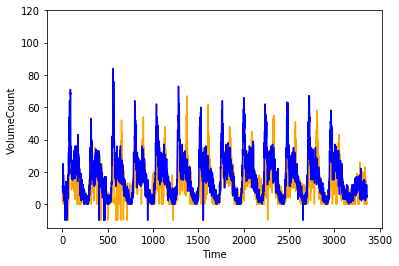

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("VolumeCount")
    plt.grid(False)

#extract State-EB-L_1 series 
series = dataset['State-EB-L_2'].values
series_output = dataset['State-EB-L_2'].values
print (series_output)
series_inputs = dataset[['Spring-WB-L_1','State-EB-L_2']].values
print (series_inputs)
time = dataset['date_time'].values

time_num = [i for i in range(len(series))]
#plot_series(time_num, series)
# plot_series(time_num, series_inputs[:,0])
# plot_series(time_num, series_inputs[:,1])

plt.plot(time_num, series_inputs[:,0], color='orange')
plt.plot(time_num, series_inputs[:,1], color='blue')
plt.xlabel("Time")
plt.ylabel("VolumeCount")
plt.grid(False)
plt.ylim(top=120)

(-13.85, 120)

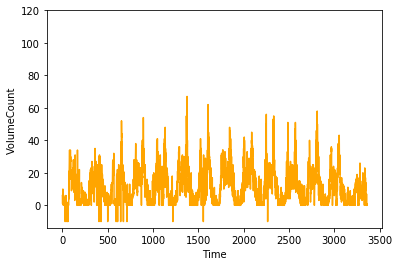

In [5]:
#plot_series(time_num, series_inputs[:,0])
plt.plot(time_num, series_inputs[:,0], color='orange')
plt.xlabel("Time")
plt.ylabel("VolumeCount")
plt.grid(False)
plt.ylim(top=120)

(-14.7, 120)

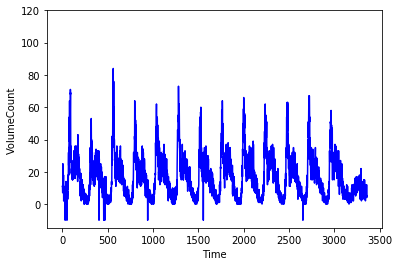

In [6]:
plt.plot(time_num, series_inputs[:,1], color='blue')
plt.xlabel("Time")
plt.ylabel("VolumeCount")
plt.grid(False)
plt.ylim(top=120)

**Split data into training and time**

**Define window_size, batch_size, and shuffle_buffer_size for modelling**

Window Size

batch Size

Shuffle uffer Size

In [7]:
num_days = 11
split_time = num_days*240
# time_train = time[:split_time]
# x_train = series[:split_time]
# time_valid = time[split_time:]
# x_valid = series[split_time:]

time_train = time[:split_time]
x_train = series_inputs[:split_time]
time_valid = time[split_time:]
x_valid = series_inputs[split_time:]

window_size = 100
batch_size = 30
shuffle_buffer_size = 100

**Creating windowed dataset**

Give explanation...



In [ ]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    #series = series.astype(np.float64)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1][1]))
    dataset = dataset.batch(batch_size).prefetch(1)
#     print (dataset)
#     for window in dataset:
#         print (window[0].shape)
    return dataset
# for window in dataset:
#     print (window)
    #dataset = dataset.map(lambda window: (window[:-1], window[-1][1]))
#dataset = dataset.map(lambda window: (window[-1]))
# dataset = dataset.batch(batch_size).prefetch(1)
# print (dataset)
    #print (dataset)
    #return dataset
# for window in dataset:
#     print (window[0].numpy())
    #print (window.numpy()[1])
    #dataset = dataset.batch(batch_size).prefetch(1)
    #print (dataset)
    #return dataset
# for window in dataset:
#     print (window[0].numpy())
#     print (window[1].numpy())
    #return dataset
# dataset = tf.data.Dataset.from_tensor_slices(series_output)
# # print (dataset)
# dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

# dataset = dataset.map(lambda window: (window[:-1], window[-1]))
# dataset = dataset.batch(batch_size).prefetch(1)
# print (dataset)

# print (dataset)
# dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
# dataset = dataset.batch(batch_size).prefetch(1)
  #return dataset


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(series_inputs)
dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1][1]))
dataset = dataset.batch(batch_size).prefetch(3)
print (dataset)
for window in dataset:
    print (window[0].shape)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

#y = tf.cast(y, tf.float32)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print (dataset)
#dataset = tf.cast(dataset, tf.float64)

model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=None),
    #tf.keras.layers.Lambda(lambda x:tf.cast(x, tf.float64)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(batch_size, window_size,2))),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),

  tf.keras.layers.Lambda(lambda x: x*100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])


In [ ]:
for window in dataset:
    print (window[0].numpy())
    print (window[1].numpy())

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 30])

In [ ]:
os.environ['PYTHONHASHSEED']=str(51)
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(batch_size, window_size,2))),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),

  tf.keras.layers.Lambda(lambda x: x*100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

In [ ]:
model.save('state_eb_multi_l2_spring.h5')

In [8]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('state_eb_multi_l2_spring.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  8960      
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  33600     
_________________________________________________________________
bidirectional_2 (Bidirection multiple                  38720     
_________________________________________________________________
bidirectional_3 (Bidirection multiple                  28928     
_________________________________________________________________
dense (Dense)                multiple                  65        
_________________________________________________________________
lambda (Lambda)              multiple                  0         
Total params: 110,273
Trainable params: 110,273
Non-trainable params: 0
__________________________________________________

(-13.863681030273437, 120)

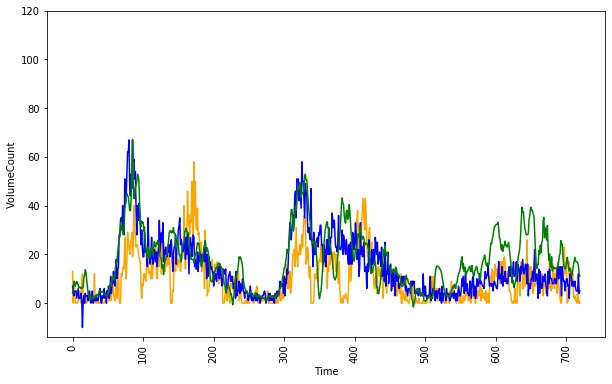

In [9]:
forecast = []
results = []
for time in range(len(series_inputs) - window_size):
  forecast.append(new_model.predict(series_inputs[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
time_valid = [i for i in range(len(time_valid))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.plot(time_valid, x_valid[:,0], color='orange')
plt.plot(time_valid, x_valid[:,1], color='blue')
plt.plot(time_valid, results, color='green')
plt.xlabel("Time")
plt.ylabel("VolumeCount")
plt.grid(False)
plt.ylim(top=120)
# plot_series(time_valid, x_valid)
# plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid[:,1], results).numpy()

6.950332

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid[:,0], results).numpy()

10.105054

In [12]:
mae = tf.keras.metrics.mean_absolute_error(x_valid[:,1], results).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(x_valid[:,1], results).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(x_valid[:,1], results).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (x_valid[:,1] - results)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 6.950332
mean squared error: 86.88067
root mean squared error: 9.320980025734242
forecast_bias: -2428.9537602066994
standard dev of errors: 8.689065130624646


## Forecast on Typical Days

In [13]:
typical_actuals = x_valid[:,1][:480]
typical_predictions = results[:480]
#print (typical_predictions)
mae = tf.keras.metrics.mean_absolute_error(typical_actuals, typical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (typical_actuals - typical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 5.8322153
mean squared error: 61.387646
root mean squared error: 7.835026848801193
forecast_bias: -465.9505670070648
standard dev of errors: 7.774659298546452


(-13.863681030273437, 120)

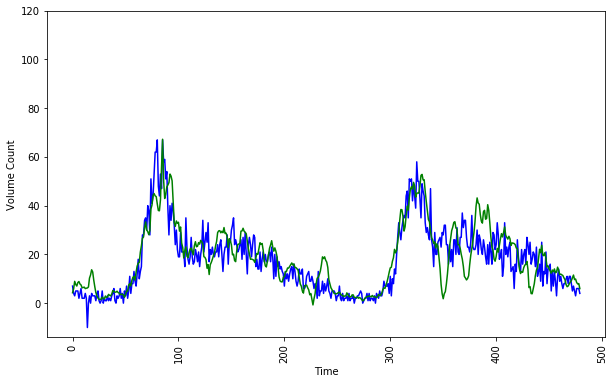

In [14]:
time_typical = [i for i in range(len(typical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_typical, typical_actuals, color = 'blue')
plt.plot(time_typical, typical_predictions, color = 'green')
plt.ylim(top=120)

## Forecast on Atypical Days

In [15]:
atypical_actuals = x_valid[:,1][-240:]
atypical_predictions = results[-240:]
#print (atypical_predictions)

mae = tf.keras.metrics.mean_absolute_error(atypical_actuals, atypical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (atypical_actuals - atypical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 9.186568
mean squared error: 137.86673
root mean squared error: 11.741666395206778
forecast_bias: -1963.0031931996346
standard dev of errors: 8.424235284611306


(-3.639672636985779, 120)

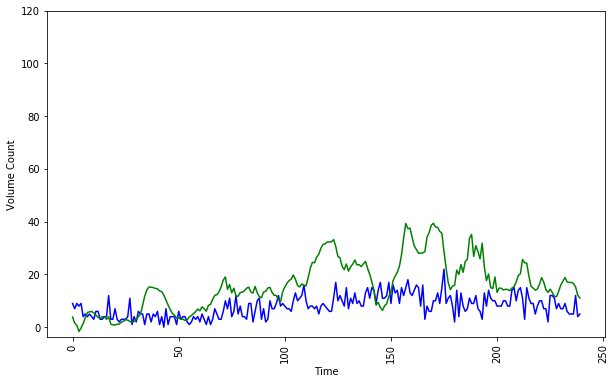

In [16]:
time_atypical = [i for i in range(len(atypical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_atypical, atypical_actuals, color = 'blue')
plt.plot(time_atypical, atypical_predictions, color = 'green')
plt.ylim(top=120)

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
forecast = []
results = []

slice_val_time = 230
sliced_val_series = x_valid[:slice_val_time]
#print (sliced_val_series)
#print (x_valid)

number_missing_units = 80
# print (sliced_val_series[-1][0])
#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
for t in range(number_missing_units):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
   # print (t)
    #if t == 0: 
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    #print (forecast)
    #else:
       # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))
    p = [[x_valid[slice_val_time+t][0],forecast[-1][0][0]]]
    #print (p)
    sliced_val_series = np.append(sliced_val_series, p, axis=0)
    #print (sliced_val_series)


#forecast = forecast[split_time-window_size:]

#results = np.array(forecast)[:, 0, 0]
#print (results)
#print (sliced_val_series)

sliced_val_actual = x_valid[:slice_val_time+number_missing_units] 
sliced_val_times = time_valid[:slice_val_time+number_missing_units]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual[:,0], color = 'orange')
plt.plot(sliced_val_times, sliced_val_actual[:,1], color = 'blue')
plt.plot(sliced_val_times, sliced_val_series[:,1], color = 'green')
plt.ylim(top=120)

#print (sliced_val_series)
# plot_series(sliced_val_times, sliced_val_actual)
# plot_series(sliced_val_times, sliced_val_series[:,1])
#print (sliced_val_series[:,1].shape)

In [ ]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()

In [ ]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,0], sliced_val_series[:,1]).numpy()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (sliced_val_actual[:,1] - sliced_val_series[:,1])
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
actuals_slice = sliced_val_actual[:,1][-80:]
predictions_slice = sliced_val_series[:,1][-80:]

mae = tf.keras.metrics.mean_absolute_error(actuals_slice, predictions_slice).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals_slice, predictions_slice).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals_slice, predictions_slice).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals_slice - predictions_slice)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

## Code for different slice time

In [ ]:
mae_array = []
rmse_array = []
std_array = []
for slice_val_time in range(100,351,10):
    forecast = []
    results = []

    #slice_val_time = 480
    sliced_val_series = x_valid[:slice_val_time]
    #print (sliced_val_series)
    #print (x_valid)

    number_missing_units = 120
    # print (sliced_val_series[-1][0])
    #forecasts only on validation part of time series
    #series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
    for t in range(number_missing_units):
        l=len(sliced_val_series)
        #print (sliced_val_series[(l-window_size):l])
       # print (t)
        #if t == 0: 
        forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
        #print (forecast)
        #else:
           # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))
        p = [[x_valid[slice_val_time+t][0],forecast[-1][0][0]]]
        #print (p)
        sliced_val_series = np.append(sliced_val_series, p, axis=0)
        #print (sliced_val_series)


    #forecast = forecast[split_time-window_size:]

    #results = np.array(forecast)[:, 0, 0]
    #print (results)
    #print (sliced_val_series)

    sliced_val_actual = x_valid[:slice_val_time+number_missing_units] 
    sliced_val_times = time_valid[:slice_val_time+number_missing_units]

    sliced_val_times = [i for i in range(len(sliced_val_times))]
    
    actuals = sliced_val_actual[:,1][-number_missing_units:]
    predictions = sliced_val_series[:,1][-number_missing_units:]
    
    mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
    print ("mean absolute error: "+ str(mae))
    mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
    print ("mean squared error: "+ str(mse))
    rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
    print ("root mean squared error: "+ str(rmse))
    array_of_errors = (actuals - predictions)
    forecast_bias = sum(array_of_errors)
    #print (array_of_errors)
    print ("forecast_bias: "+ str(forecast_bias))
    std_dev_errors = np.std(array_of_errors)
    print ("standard dev of errors: "+ str(std_dev_errors))
    
    mae_array.append(mae)
    rmse_array.append(rmse)
    std_array.append(std_dev_errors)

In [ ]:
print (mae_array)
print (rmse_array)
print (std_array)

## Model Performance on 18th March for Simulation Experiment

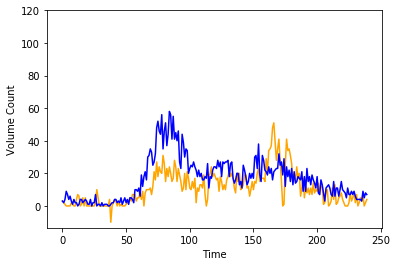

In [11]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata.csv', header=0, index_col=None)

## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
dataset_original = dataset_orginal[:-240]
dataset_original=dataset_original[dataset_original['date_time'].str.contains("3/18/2019")==True]

#extract State-EB-L_1 series for 18th March
#series_18march = dataset_original['State-EB-L_1'].values
series_18march = dataset_original[['Spring-WB-L_1','State-EB-L_2']].values
time_18march = dataset_original['date_time'].values

time_num_18march = [i for i in range(len(series_18march))]

# Plot the 18th March data
plt.plot(time_num_18march, series_18march[:,0], color='orange')
plt.plot(time_num_18march, series_18march[:,1], color='blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=120)
plt.grid(False)

(-13.4, 120)

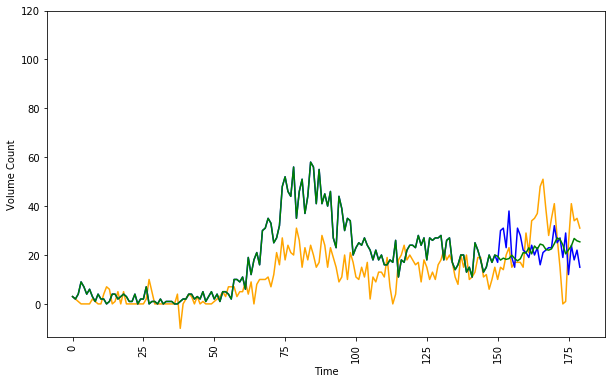

In [12]:
##apply model to the 18th march data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_18march[:slice_val_time]
#print (sliced_val_series)
#print (x_valid)

number_missing_units = 30
# print (sliced_val_series[-1][0])
#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
for t in range(number_missing_units):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
   # print (t)
    #if t == 0: 
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    #print (forecast)
    #else:
       # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))
    p = [[series_18march[slice_val_time+t][0],forecast[-1][0][0]]]
    #print (p)
    sliced_val_series = np.append(sliced_val_series, p, axis=0)
    #print (sliced_val_series)


#forecast = forecast[split_time-window_size:]

#results = np.array(forecast)[:, 0, 0]
#print (results)
#print (sliced_val_series)

sliced_val_actual = series_18march[:slice_val_time+number_missing_units] 
sliced_val_times = time_18march[:slice_val_time+number_missing_units]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual[:,0], color = 'orange')
plt.plot(sliced_val_times, sliced_val_actual[:,1], color = 'blue')
plt.plot(sliced_val_times, sliced_val_series[:,1], color = 'green')
plt.ylim(top=120)

In [13]:
actuals_18Mar = sliced_val_actual[:,1][-30:]
print (actuals_18Mar)
predictions_18Mar = sliced_val_series[:,1][-30:]
print (predictions_18Mar)

mae = tf.keras.metrics.mean_absolute_error(actuals_18Mar, predictions_18Mar).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals_18Mar, predictions_18Mar).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals_18Mar, predictions_18Mar).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals_18Mar - predictions_18Mar)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))


# mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
# print ("mean absolute error: "+ str(mae))
# mse = tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
# print ("mean squared error: "+ str(mse))
# rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy())
# print ("root mean squared error: "+ str(rmse))
# array_of_errors = (sliced_val_actual[:,1] - sliced_val_series[:,1])
# forecast_bias = sum(array_of_errors)
# #print (array_of_errors)
# print ("forecast_bias: "+ str(forecast_bias))
# std_dev_errors = np.std(array_of_errors)
# print ("standard dev of errors: "+ str(std_dev_errors))

[17. 30. 31. 23. 38. 19. 15. 31. 28. 22. 21. 19. 24. 20. 23. 16. 21. 22.
 23. 23. 32. 25. 27. 19. 29. 12. 24. 18. 22. 15.]
[19.49104118 17.93013    18.72032928 18.22193527 18.52662277 19.92572021
 18.58067894 17.61367989 18.45311165 20.96149826 20.81666374 22.94716454
 20.47077942 23.68548775 22.4452343  24.46924973 24.07709885 22.27805328
 21.98945999 22.50442123 24.62375832 26.96912003 26.39822388 24.16613197
 20.48209381 22.12435532 23.68908119 26.76545906 25.80806541 25.38617897]
mean absolute error: 5.39422607421875
mean squared error: 52.467077044548205
root mean squared error: 7.243416117036782
forecast_bias: 28.479171752929688
standard dev of errors: 7.180939749423121


In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_state_eb_l2_multivariate_18mar.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_state_eb_l2_multivariate_18mar.csv")

## Model Performance on 27 May (Memorial Day) for Simulation Experiment

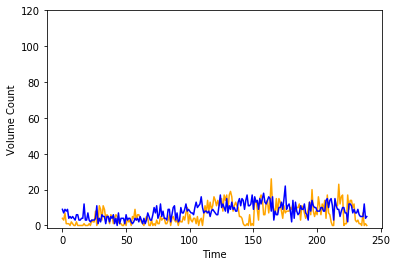

In [14]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
dataset_original = dataset_orginal[:-240]
dataset_original=dataset_original[dataset_original['date_time'].str.contains("5/27/2019")==True]

#extract State-EB-L_1 series for 27th May
#series_18march = dataset_original['State-EB-L_1'].values
series_27may = dataset_original[['Spring-WB-L_1','State-EB-L_2']].values
time_27may = dataset_original['date_time'].values

time_num_27may = [i for i in range(len(series_18march))]

# Plot the 18th March data
plt.plot(time_num_27may, series_27may[:,0], color='orange')
plt.plot(time_num_27may, series_27may[:,1], color='blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=120)
plt.grid(False)

#print (series_27may)

(-1.9073486328125, 120)

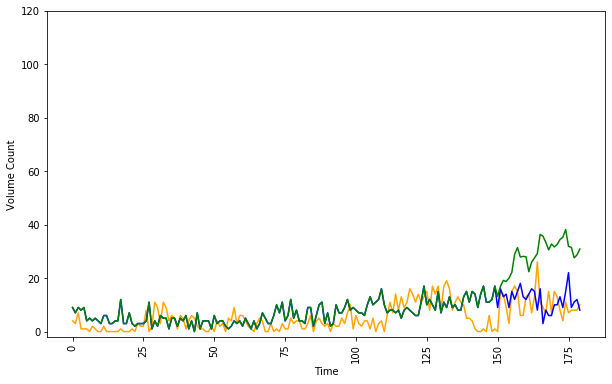

In [15]:
##apply model to the 27 May data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_27may[:slice_val_time]
#print (sliced_val_series)
#print (x_valid)

number_missing_units = 30
# print (sliced_val_series[-1][0])
#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
for t in range(number_missing_units):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
   # print (t)
    #if t == 0: 
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    #print (forecast)
    #else:
       # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))

    p = [[series_27may[slice_val_time+t][0],forecast[-1][0][0]]]
    #print (p)
    #p = [sliced_val_series,p]
    sliced_val_series = np.append(sliced_val_series, p, axis=0)
    #print (sliced_val_series)
    #forecast = forecast[split_time-window_size:]

#results = np.array(forecast)[:, 0, 0]
#print (results)
# print (sliced_val_series)
# print (sliced_val_actual)
sliced_val_actual = series_27may[:slice_val_time+number_missing_units] 
sliced_val_times = time_27may[:slice_val_time+number_missing_units]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual[:,0], color = 'orange')
plt.plot(sliced_val_times, sliced_val_actual[:,1], color = 'blue')
plt.plot(sliced_val_times, sliced_val_series[:,1], color = 'green')
plt.ylim(top=120)

In [16]:
actuals_27May = sliced_val_actual[:,1][-30:]
print (actuals_27May)
predictions_27May = sliced_val_series[:,1][-30:]
print (predictions_27May)

mae = tf.keras.metrics.mean_absolute_error(actuals_27May, predictions_27May).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals_27May, predictions_27May).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals_27May, predictions_27May).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals_27May - predictions_27May)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))


# mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
# print ("mean absolute error: "+ str(mae))
# mse = tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
# print ("mean squared error: "+ str(mse))
# rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy())
# print ("root mean squared error: "+ str(rmse))
# array_of_errors = (sliced_val_actual[:,1] - sliced_val_series[:,1])
# forecast_bias = sum(array_of_errors)
# #print (array_of_errors)
# print ("forecast_bias: "+ str(forecast_bias))
# std_dev_errors = np.std(array_of_errors)
# print ("standard dev of errors: "+ str(std_dev_errors))

[ 9. 16. 13. 14.  9. 15. 12. 15. 18. 13. 12. 14. 16. 15.  8. 16.  3.  8.
  6.  6. 10. 10. 13.  9. 15. 22.  9. 11. 12.  8.]
[13.22112083 16.9665432  19.1109066  18.72815704 19.95840263 22.15571785
 28.92310715 31.37262535 27.86341667 28.09981346 27.94296074 22.3753624
 26.01079941 27.50695419 29.17677116 36.33511734 35.65060425 33.31337738
 30.52104187 32.75352478 31.62853622 32.5387764  34.39986038 35.27709579
 38.14697266 31.86768913 31.48979568 27.57107353 28.64685631 30.84343338]
mean absolute error: 16.44654712677002
mean squared error: 331.1000474734379
root mean squared error: 18.196154744160587
forecast_bias: -493.3964138031006
standard dev of errors: 7.785315348807052


In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_state_eb_l2_multivariate_27may.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_state_eb_l2_multivariate_27may.csv")